In [1]:
# Process Description Column

In [1]:
import os
# show current dir
os.chdir("..")
os.getcwd()

'c:\\Users\\Kyriakos\\Desktop\\MsC AI\\NLP\\NLP AirBNB Project\\AirBnB_score_prediction'

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from transformers import BertTokenizer, BertModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

import pickle

In [4]:
# read data 

listings = pd.read_csv("dataset\listings\listings.csv")


In [5]:
listings.review_scores_rating.head()

0    4.89
1    4.76
2    4.75
3    4.94
4    4.88
Name: review_scores_rating, dtype: float64

## Visualization of target variables


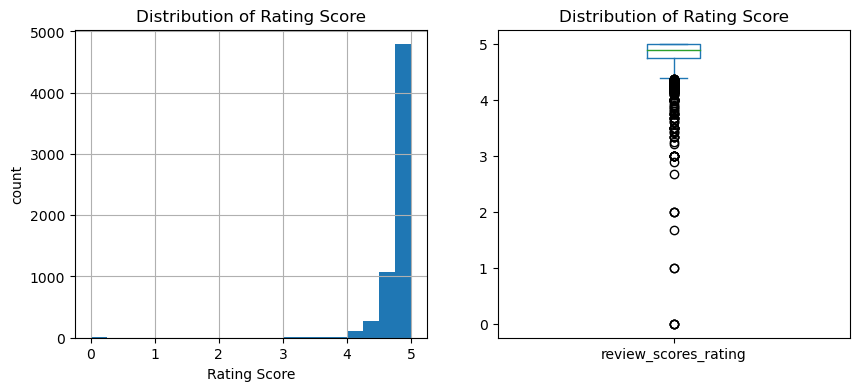

In [6]:
# The Rating score column
fig = plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

listings.review_scores_rating.hist(ax = ax1, bins = 20)
ax1.set_title('Distribution of Rating Score')
ax1.set_xlabel('Rating Score')
ax1.set_ylabel('count')

# The Log Price column
plot = listings.review_scores_rating.plot(kind = 'box', ax = ax2)
ax2.set_title('Distribution of Rating Score')

plt.show()

In [7]:
# check na in rating score
listings.review_scores_rating.isna().sum()
# fill na with mean
listings.review_scores_rating.fillna(listings.review_scores_rating.mean(), inplace = True)

In [8]:
import numpy as np


# open multilingual comments
with open('embeddings\multilingual_comments_embeddings.pkl', 'rb') as f:
    multilingual_comments_embeddings = pickle.load(f)

y = listings.review_scores_rating.values

# remove the rows with review_scores_rating == 5.0 on y and the same index on multilingual_comments_embeddings
# Find the indices of rows with review_scores_rating == 5.0
idx = np.where(listings.review_scores_rating.values == 5.0)[0]

# Remove the rows from multilingual_comments_embeddings and y
multilingual_comments_embeddings = np.delete(multilingual_comments_embeddings, idx, axis=0)
y = np.delete(y, idx)



# merge into a new dataframe
df = pd.DataFrame(multilingual_comments_embeddings)
df['review_scores_rating'] = y



We can bin the Review ratings

Text(0, 0.5, 'count')

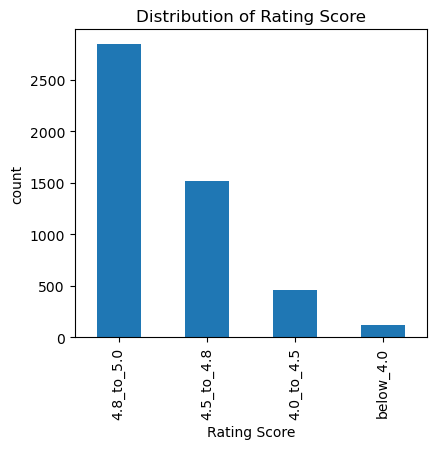

In [9]:
# Create bins based on review_scores_rating
bins = [0, 4.0, 4.5, 4.8, 5]

listings_classification = df.assign(
    rating_bin_ep = pd.cut(
        df['review_scores_rating'],
        bins=bins,
        labels=['below_4.0', '4.0_to_4.5', '4.5_to_4.8', '4.8_to_5.0']
    )
)

# Visualize the Split
fig = plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(1,2,1)

listings_classification.rating_bin_ep.value_counts().plot(kind = 'bar', ax = ax1)
ax1.set_title('Distribution of Rating Score')
ax1.set_xlabel('Rating Score')
ax1.set_ylabel('count')




In [11]:
listings_classification.rating_bin_ep.value_counts()

4.8_to_5.0    2845
4.5_to_4.8    1519
4.0_to_4.5     461
below_4.0      120
Name: rating_bin_ep, dtype: int64

In [55]:
# listings_classification.rating_bin_ep.value_counts(normalize=True)

In [50]:
# # find all values that are not float and convert them to float
# for i in range(len(listings.review_scores_rating)):
#     if type(listings.review_scores_rating[i]) != float:
#         listings.review_scores_rating[i] = float(listings.review_scores_rating[i])


In [12]:
print(listings_classification.rating_bin_ep.isna().sum()
)# fill na with most occuring value
listings_classification.rating_bin_ep.fillna('4.8_to_5.0', inplace = True)

listings_classification.rating_bin_ep.isna().sum()

4


0

## apply lgbm clasifier to predict the correct bin


In [13]:
# show continues variables in y
listings_classification.rating_bin_ep

0       4.8_to_5.0
1       4.5_to_4.8
2       4.5_to_4.8
3       4.8_to_5.0
4       4.8_to_5.0
           ...    
4944    4.8_to_5.0
4945    4.8_to_5.0
4946    4.8_to_5.0
4947    4.8_to_5.0
4948    4.8_to_5.0
Name: rating_bin_ep, Length: 4949, dtype: category
Categories (4, object): ['below_4.0' < '4.0_to_4.5' < '4.5_to_4.8' < '4.8_to_5.0']

In [14]:
listings_classification.review_scores_rating

0       4.89000
1       4.76000
2       4.75000
3       4.94000
4       4.88000
         ...   
4944    4.81804
4945    4.81804
4946    4.81804
4947    4.81804
4948    4.81804
Name: review_scores_rating, Length: 4949, dtype: float64

In [67]:
# define X and y
X = listings_classification.drop(['rating_bin_ep', "review_scores_rating"], axis = 1)
y = listings_classification.rating_bin_ep

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train model
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
# impor model
model = lgb.LGBMClassifier()
# fit model
model.fit(X_train, y_train)
# predict
y_pred = model.predict(X_test)






In [68]:
# evaluate
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))

print('Classification report: \n', classification_report(y_test, y_pred))


Accuracy score:  0.5878787878787879
F1 score:  0.538084974496982
Confusion matrix: 
 [[  7  35  45   0]
 [  4 100 224   0]
 [  1  74 475   0]
 [  6  12   7   0]]
Classification report: 
               precision    recall  f1-score   support

  4.0_to_4.5       0.39      0.08      0.13        87
  4.5_to_4.8       0.45      0.30      0.36       328
  4.8_to_5.0       0.63      0.86      0.73       550
   below_4.0       0.00      0.00      0.00        25

    accuracy                           0.59       990
   macro avg       0.37      0.31      0.31       990
weighted avg       0.54      0.59      0.54       990



c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


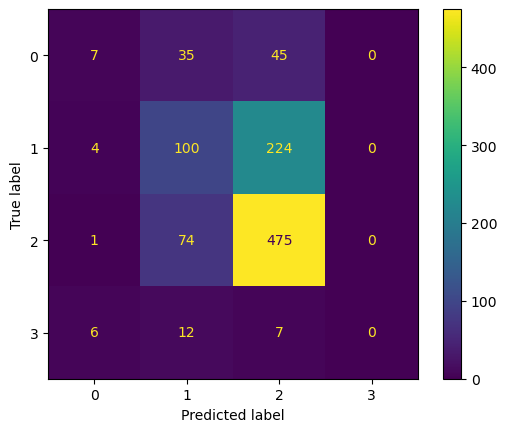

In [69]:
# fig show confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
 ## Confusion
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()



## random forrest

Accuracy score:  0.602020202020202
F1 score:  0.5244849165062087
Classification report: 
               precision    recall  f1-score   support

  4.0_to_4.5       0.50      0.01      0.02        87
  4.5_to_4.8       0.53      0.24      0.33       328
  4.8_to_5.0       0.62      0.94      0.74       550
   below_4.0       0.00      0.00      0.00        25

    accuracy                           0.60       990
   macro avg       0.41      0.30      0.27       990
weighted avg       0.56      0.60      0.52       990



c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Kyriakos\anaconda3\envs\nlp1\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


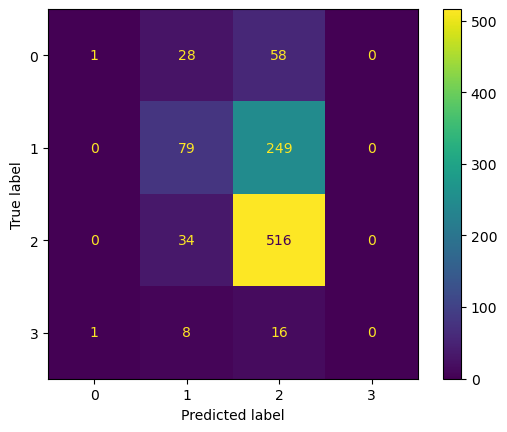

In [72]:
from sklearn.ensemble import RandomForestClassifier

# impor model
model = RandomForestClassifier()

# fit model
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
print('Classification report: \n', classification_report(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()



## SVM

In [15]:
# pply with scv
from sklearn.svm import SVC
# define X and y
X = listings_classification.drop(['rating_bin_ep', "review_scores_rating"], axis = 1)
y = listings_classification.rating_bin_ep

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# impor model
model = SVC()

# fit model
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred, average='weighted'))
print('Classification report: \n', classification_report(y_test, y_pred))

cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()



: 

: 

## apply the mlp classifier to predict the correct bin


In [71]:
from model.models.classifier import MLPClassifier

# convert to tensor and float
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

# impor model
input_dim = X_train.shape[1]
output_dim = len(np.unique(y_train))
hidden_dim = 100

model = MLPClassifier(input_dim, hidden_dim, output_dim)

# fit model
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate


KeyError: 8

In [76]:
# Create equal probability bins at the PENTILES of RATING
# labels below_4.3, 4.3_to_4.8, 4.8_to_5
labels = [0,1,2]


listings['review_scores_rating'] = pd.qcut(
        listings['review_scores_rating'],
        q=3,
        duplicates='drop',
        labels=labels
    )

# Visualize the Split
sns.countplot(listings['review_scores_rating'])

# add plot title and axis labels
plt.title('Distribution of Review Scores')
plt.xlabel('Review Scores')
plt.ylabel('Number of Listings')

# display the plot
plt.show()



ValueError: could not convert string to float: '4.3_to_4.8'

In [13]:
# discretize review_scores_rating
listings['review_scores_rating'] = pd.cut(listings['review_scores_rating'], bins=5,
                                         labels=['0.0-1.0', '1.0-2.0', '2.0-3.0', '3.0-4.0', '4.0-5.0'])

# replace null values in description and review_scores_rating
listings['description'].replace(np.NaN, 'no_description', inplace=True)
listings['review_scores_rating'].replace(np.NaN, 'no_review', inplace=True)

In [14]:
listings.review_scores_rating.head()

0    4.0-5.0
1    4.0-5.0
2    4.0-5.0
3    4.0-5.0
4    4.0-5.0
Name: review_scores_rating, dtype: category
Categories (5, object): ['0.0-1.0' < '1.0-2.0' < '2.0-3.0' < '3.0-4.0' < '4.0-5.0']

In [15]:
listings.review_scores_rating.value_counts()

4.0-5.0    6037
3.0-4.0     110
2.0-3.0       6
0.0-1.0       4
1.0-2.0       4
Name: review_scores_rating, dtype: int64

In [22]:
from nltk.corpus import stopwords
import nltk


# Snipped to execute the download of nltk moule only if not present
nltk.download("stopwords")
nltk.download('punkt')

ENGLISH_STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kyriakos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kyriakos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
!python -m spacy download en_core_web_sm

2023-04-21 16:39:55.542120: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2023-04-21 16:39:55.542506: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-21 16:39:58.361629: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library nvcuda.dll
2023-04-21 16:39:58.362074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.4425GHz coreCount: 6 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 104.43GiB/s
2023-04-21 16:39:58.364664: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2023-04-21 16:39:58.366871: W tensorflow/stream_execu


     ---------------------------------------- 12.8/12.8 MB 4.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [30]:
# import libraries for handling text
import scattertext as st
import spacy

from pprint import pprint

from sentence_transformers import SentenceTransformer
# nlp = SentenceTransformer('distiluse-base-multilingual-cased-v2')
# load SBERT
nlp = spacy.load("en_core_web_sm")

# create a scattertext corpus & look for differences between listing descriptions in ratings
# remove stop words
corpus = (st.CorpusFromPandas(listings,
                              category_col='review_scores_rating',
                              text_col='description',
                              nlp=nlp)
          .build()
          .remove_terms(ENGLISH_STOP_WORDS, ignore_absences=True))

# generate scatterplot and save to HTML file
# set a minimum term frequency to filter out infrequent words
html = st.produce_scattertext_explorer(corpus,
          category='4.0-5.0',
          category_name='Star Rating 4.0 - 5.0',
          not_category_name='All Other Ratings',
          width_in_pixels=1000,
          minimum_term_frequency=200)
open('term-associations.html', 'wb').write(html.encode('utf-8'))

5510361

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Read in the data from the HTML file
df = pd.read_html('term-associations.html')[0]
# df = pd.read_html('term-associations.html', flavor='html5lib')[0]


# Create a scatterplot using Matplotlib
plt.scatter(df['x'], df['y'])

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot')

# Show the plot
plt.show()


ImportError: lxml not found, please install it